# RecA deep mutational scanning libraries
This example shows how to process PacBio circular consensus sequencing of a barcoded library of RecA variants for deep mutational scanning.
Note it just uses a snippet of the full data set of circular consensus sequences so that the example is small and fast.

## Set up for analysis
Import necessary Python modules:

In [1]:
import os
import tempfile
import warnings

import Bio.SeqIO

import pandas as pd

import pysam

import alignparse.ccs
import alignparse.minimap2
import alignparse.targets

Suppress warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

Directory for output:

In [3]:
outdir = './output_files/'
os.makedirs(outdir, exist_ok=True)

## Target amplicon
We have performed sequencing of an amplicon that includes mutants of RecA along with barcodes and several other features.
The amplicon is defined as a Genbank file.
First, let's just look at that file:

In [4]:
recA_targetfile = 'input_files/recA_amplicon.gb'

with open(recA_targetfile) as f:
    print(f.read())

LOCUS       RecA_PacBio_amplicon    1342 bp ds-DNA     linear       06-AUG-2018
DEFINITION  PacBio amplicon for deep mutational scanning of E. coli RecA.
ACCESSION   None
VERSION     
SOURCE      Danny Lawrence
  ORGANISM  .
COMMENT     PacBio amplicon for RecA libraries.
COMMENT     There are single nucleotide tags in the 5' and 3' termini to measure strand exchange.
FEATURES             Location/Qualifiers
     termini5        1..147
                     /label="termini 5' of gene"
     gene            148..1206
                     /label="RecA gene"
     spacer          1207..1285
                     /label="spacer between gene & barcode"
     barcode         1286..1303
                     /label="18 nucleotide barcode"
     termini3        1304..1342
                     /label="termini 3' of barcode"
     variant_tag5    33..33
                     /label="5' variant tag"
     variant_tag3    1311..1311
                     /label="3' variant tag"
ORIGIN
        1 gcacggcgtc ac

Read this amplicon into a `Targets` object, specifying the features that we require the target to contain:

In [5]:
targets = alignparse.targets.Targets(
                seqsfile=recA_targetfile,
                req_features=['termini5', 'gene', 'spacer', 'barcode',
                              'termini3', 'variant_tag5', 'variant_tag3'])

Plot the targets:

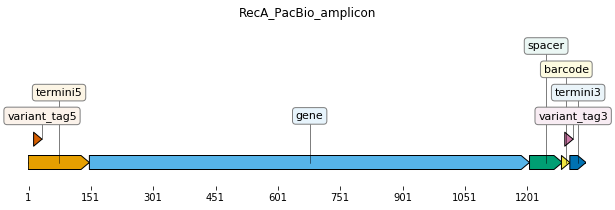

In [6]:
_ = targets.plot(ax_width=10)

We can write them to a file for alignment:

## PacBio CCSs
We will align PacBio circular consensus sequences (CCSs) to the target.
First, we want to look at the CCSs.
A FASTQ file with these CCSs along with an associated report file were generated using the PacBio `ccs` program (see [here](https://github.com/PacificBiosciences/ccs) for details on `ccs`) using commands like the following (generates report file and BAM of CCSs):

    ccs --minLength 50 --maxLength 5000 \
        --minPasses 3  --minPredictedAccuracy 0.999 \
        --reportFile recA_lib-1_report.txt \
        --polish --numThreads 16 \
        recA_lib-1_subreads.bam lib-1_ccs.bam
        
The BAM file was then converted to a FASTQ file using [samtools](http://www.htslib.org/) with flags to retain the number of passes (`np`) and read quality (`rq`) flags:

    samtools bam2fq -T np,rq lib-1_ccs.bam > lib-1_ccs.fastq
    
Here is a data frame with the resulting FASTQ and BAM files:

In [7]:
run_names = ['recA_lib-1', 'recA_lib-2']
ccs_dir = 'input_files'

pacbio_runs = pd.DataFrame(
            {'name': run_names,
             'report': [f"{ccs_dir}/{name}_report.txt" for name in run_names],
             'fastq': [f"{ccs_dir}/{name}_ccs.fastq" for name in run_names]
             })

pacbio_runs

,name,report,fastq
0,recA_lib-1,input_files/recA_lib-1_report.txt,input_files/recA_lib-1_ccs.fastq
1,recA_lib-2,input_files/recA_lib-2_report.txt,input_files/recA_lib-2_ccs.fastq


We create a `Summaries` object for these CCSs:

In [8]:
ccs_summaries = alignparse.ccs.Summaries(pacbio_runs)

Plot how many ZMWs yielded CCSs:

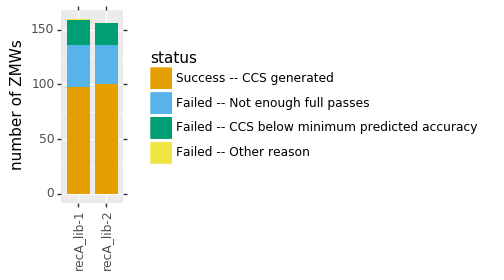

In [9]:
p = ccs_summaries.plot_zmw_stats()
_ = p.draw()

Statistics on the CCSs (length, number of subread passes, quality):

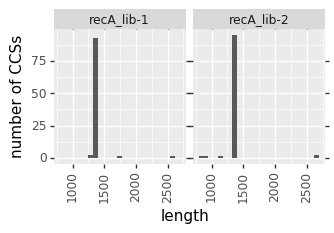

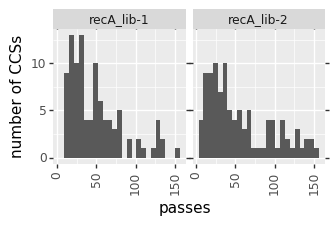

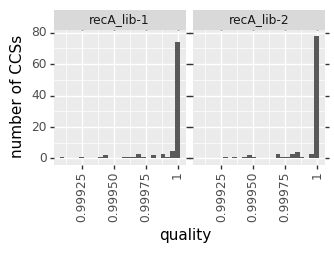

In [10]:
for stat in ['length', 'passes', 'quality']:
    p = ccs_summaries.plot_ccs_stats(stat)
    _ = p.draw()

## Align CCSs to target
Now we use `minimap2` to align the CCSs to the target.

First, we create a `Mapper` object to run `minimap2`, using the options for codon-level deep mutational scanning:

In [11]:
mapper = alignparse.minimap2.Mapper(
            options=alignparse.minimap2.OPTIONS_CODON_DMS)

print(f"Using `minimap2` {mapper.version} with these options:\n{' '.join(mapper.options)}")

Using `minimap2` 2.17-r941 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --score-N=4 --secondary=no --cs


Now use this mapper to do the alignments to a SAM file.
First, add the names of the desired alignment files to our data frame:

In [12]:
pacbio_runs = pacbio_runs.assign(alignments=lambda x: outdir + x['name'] + '_alignments.sam')

pacbio_runs

,name,report,fastq,alignments
0,recA_lib-1,input_files/recA_lib-1_report.txt,input_files/recA_lib-1_ccs.fastq,./output_files/recA_lib-1_alignments.sam
1,recA_lib-2,input_files/recA_lib-2_report.txt,input_files/recA_lib-2_ccs.fastq,./output_files/recA_lib-2_alignments.sam


Now use the mapper to actually align the FASTQ queries to the target:

In [13]:
for tup in pacbio_runs.itertuples(index=False):
    print(f"Aligning {tup.fastq} to create {tup.alignments}...")
    targets.align(queryfile=tup.fastq,
                  alignmentfile=tup.alignments,
                  mapper=mapper)

Aligning input_files/recA_lib-1_ccs.fastq to create ./output_files/recA_lib-1_alignments.sam...
Aligning input_files/recA_lib-2_ccs.fastq to create ./output_files/recA_lib-2_alignments.sam...


These SAM files now contain the alignments along with the [`cs` tag](https://github.com/lh3/minimap2#cs), which contains details on the mutations:

In [14]:
for fname in pacbio_runs['alignments'][:1]:
    with pysam.AlignmentFile(fname) as f:
        a = next(f)
    print(f"First alignment in {fname} has following `cs` tag:\n\n{a.get_tag('cs')}\n\n"
          f"and the following full line:\n\n{a.to_string()}"
          )

First alignment in ./output_files/recA_lib-1_alignments.sam has following `cs` tag:

:32*ng:234*ag*tg*cg:93+a:268+a:416*ca*at*gt:235*ng*ng*nt*nc*na*nc*nt*na*ng*ng*ng*na*ng*na*ng*nc*nt*nt:7*nc:31

and the following full line:

m54228_181120_212724/4194370/ccs	16	RecA_PacBio_amplicon	1	60	363M1I268M1I711M	*	0	0	GCACGGCGTCACACTTTGCTATGCCATAGCATGTTTATCCATAAGATTAGCGGATCCTACCTGACGCTTTTTATCGCAACTCTCTACTGTTTCTCCATAACAGAACATATTGACTATCCGGTATTACCCGGCATGACAGGAGTAAAAATGGCTATCGACGAAAACAAACAGAAAGCGTTGGCGGCAGCACTGGGCCAGATTGAGAAACAATTTGGTAAAGGCTCCATCATGCGCCTGGGTGAAGACCGTTCCATGGATGTGGAAACCGGGTCTACCGGTTCGCTTTCACTGGATATCGCGCTTGGGGCAGGTGGTCTGCCGATGGGCCGTATCGTCGAAATCTACGGACCGGAATCTTCCGGTAAAAACCACGCTGACGCTGCAGGTGATCGCCGCAGCGCAGCGTGAAGGTAAAACCTGTGCGTTTATCGATGCTGAACACGCGCTGGACCCAATCTACGCACGTAAACTGGGCGTCGATATCGACAACCTGCTGTGCTCCCAGCCGGACACCGGCGAGCAGGCACTGGAAATCTGTGACGCCCTGGCGCGTTCTGGCGCAGTAGACGTTATCGTCGTTGACTCCGTGGCGGCACTGACGCCGAAAGCGGAAATCGAAGGCGAAATCGGCGAACTCTCATATGGGCCTTGCGGCACGTATGATGAGCCAGGCGATGCGTAAGCTGGCG